In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose  # For time series decomposition
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test for stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF and PACF plots
from pmdarima import auto_arima  # Automated ARIMA model selection
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Seasonal ARIMA model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Evaluation metrics
import itertools

**Data Exploration and Preprocessing**

In [2]:
df = pd.read_csv('Perrin Freres monthly champagne sales millions.csv')##upload datast

In [3]:
df.head()

,Month,Sale
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [4]:
df.tail()

,Month,Sale
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


In [5]:
df.sample(8)

,Month,Sale
48,1968-01,3633
61,1969-02,3957
30,1966-07,3260
95,1971-12,12670
6,1964-07,2282
96,1972-01,4348
21,1965-10,4474
64,1969-05,4968


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sale    105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [7]:
df.shape

(105, 2)

In [8]:
df.isnull().sum()

Month    0
Sale     0
dtype: int64

In [9]:
df.describe(include='object').T

,count,unique,top,freq
Month,105,105,1964-01,1


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sale,105.0,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


In [11]:
#convert month into datetime format
df.Month=pd.to_datetime(df.Month)

In [12]:
# Set the 'Month' column as the index (required for seasonal decomposition)
df.set_index('Month', inplace=True)

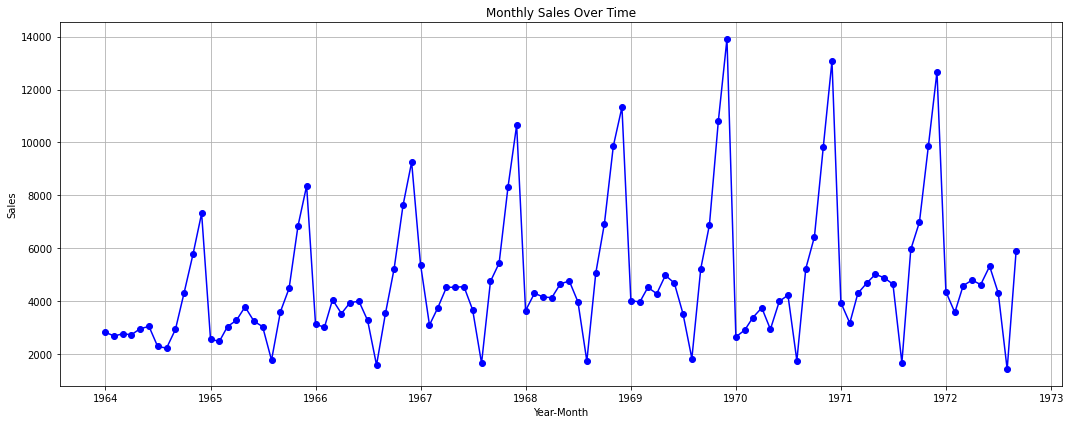

In [13]:
# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Sale'], marker='o', linestyle='-', color='b')

# Customize the plot
plt.title('Monthly Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

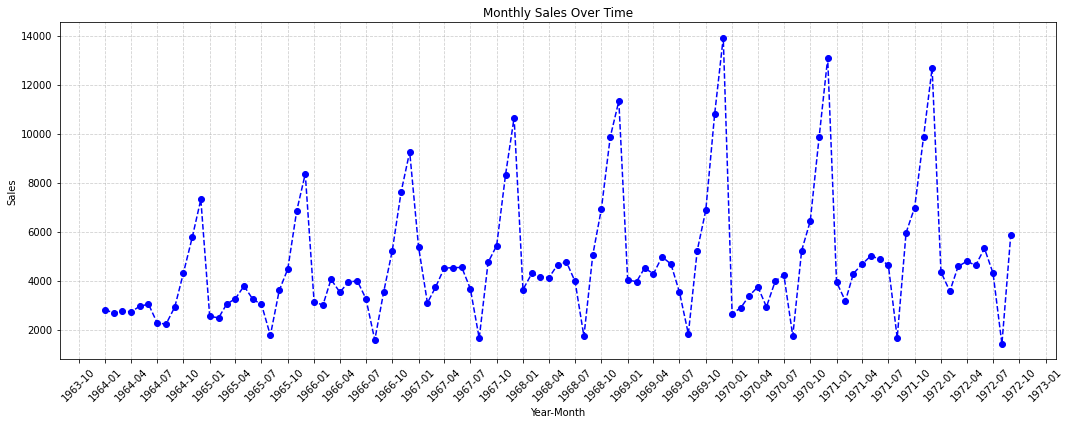

In [14]:
plt.figure(figsize=(15, 6))

# Plot the data with markers 
plt.plot(df.index, df['Sale'], marker='o', linestyle='--', color='b', label='Monthly Sales')


plt.title('Monthly Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales')


plt.grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Format the x-axis date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show labels every 3 months


#Tighten the layout for a better fit
plt.tight_layout()


plt.show()


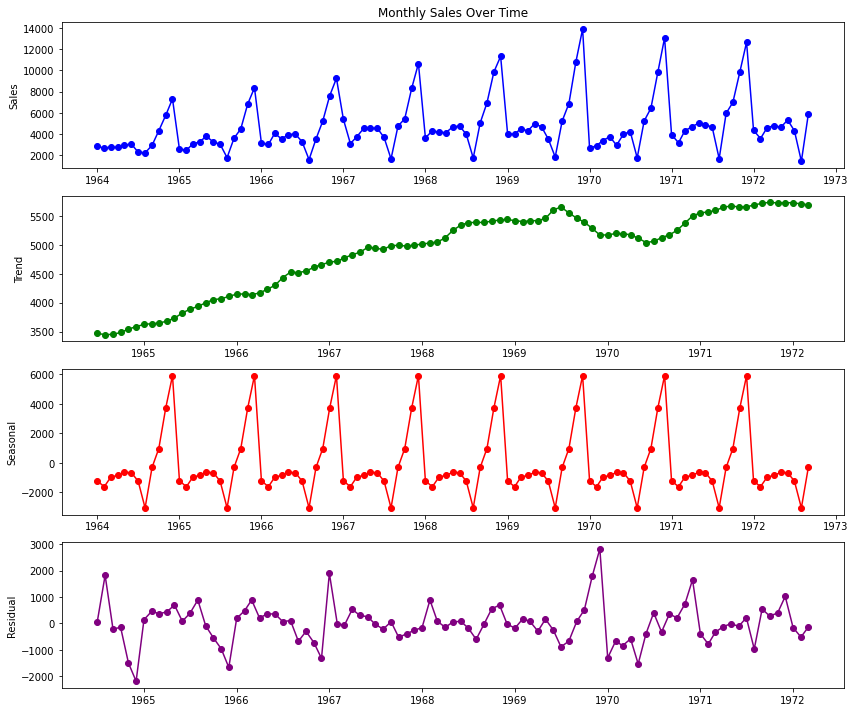

In [15]:
#seasonal decomposition
result = seasonal_decompose(df['Sale'], model='additive')

# Create a subplot for the decomposition components
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))

# Plot the original time series
axes[0].plot(df.index, df['Sale'], marker='o', linestyle='-', color='b')
axes[0].set_ylabel('Sales')
axes[0].set_title('Monthly Sales Over Time')

# Plot the trend component
axes[1].plot(result.trend, marker='o', linestyle='-', color='g')
axes[1].set_ylabel('Trend')

# Plot the seasonal component
axes[2].plot(result.seasonal, marker='o', linestyle='-', color='r')
axes[2].set_ylabel('Seasonal')

# Plot the residual component
axes[3].plot(result.resid, marker='o', linestyle='-', color='purple')
axes[3].set_ylabel('Residual')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

**Feature Engineering**

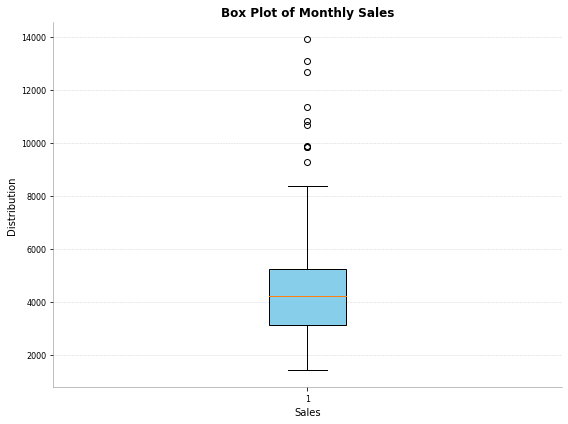

In [16]:
# Set custom color for the box plot
box_color = 'skyblue'

# Plotting the boxplot
plt.figure(figsize=(8, 6))  # Set the figure size as desired
plt.boxplot(df['Sale'], patch_artist=True, boxprops=dict(facecolor=box_color))

# Adding titles and labels
plt.title('Box Plot of Monthly Sales', fontsize=12, fontweight='bold')
plt.xlabel('Sales', fontsize=10)
plt.ylabel('Distribution', fontsize=10)

# Customize font style and size for tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Customize border colors and line widths
plt.setp(plt.gca().spines.values(), color='gray', linewidth=0.5)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show gridlines and customize grid style
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='lightgray')

# Showing the plot
plt.tight_layout()  # Adjust the spacing between elements for better aesthetics
plt.show()


In [17]:
# Winsorization replaces extreme values in the series with specified quantile values.
def winsorize(series, lower_quantile=0.05, upper_quantile=0.95):
    # Calculate the lower bound based on the specified lower quantile.
    lower_bound = series.quantile(lower_quantile)
    
    # Calculate the upper bound based on the specified upper quantile.
    upper_bound = series.quantile(upper_quantile)
    
    # Replace values below the lower bound with the lower bound.
    series = np.where(series < lower_bound, lower_bound, series)
    
    # Replace values above the upper bound with the upper bound.
    series = np.where(series > upper_bound, upper_bound, series)
    
    return series

# Apply winsorization to the 'Sale' column of the DataFrame 'df'.
df['Sale'] = winsorize(df['Sale'])


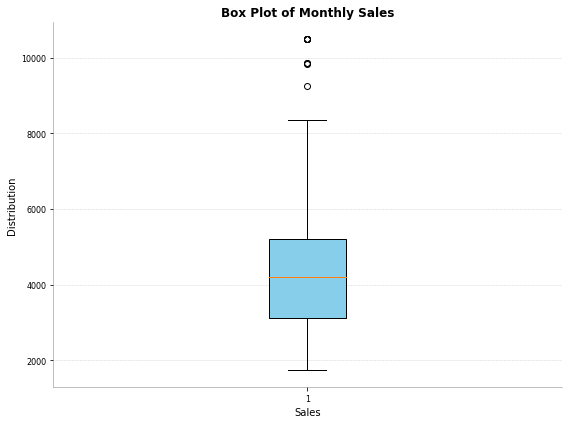

In [18]:
# Set custom color for the box plot
box_color = 'skyblue'

# Plotting the boxplot
plt.figure(figsize=(8, 6))  # Set the figure size as desired
plt.boxplot(df['Sale'], patch_artist=True, boxprops=dict(facecolor=box_color))

# Adding titles and labels
plt.title('Box Plot of Monthly Sales', fontsize=12, fontweight='bold')
plt.xlabel('Sales', fontsize=10)
plt.ylabel('Distribution', fontsize=10)

# Customize font style and size for tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Customize border colors and line widths
plt.setp(plt.gca().spines.values(), color='gray', linewidth=0.5)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show gridlines and customize grid style
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='lightgray')

# Showing the plot
plt.tight_layout()  # Adjust the spacing between elements for better aesthetics
plt.show()

In [19]:
#df['month']= df.index

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sale    105 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [21]:
rolling_mean=df.rolling(window=12).mean()
rolling_std_dev=df.rolling(window=12).std()
print(rolling_mean)
print("------------------------------")
print(rolling_std_dev)

                   Sale
Month                  
1964-01-01          NaN
1964-02-01          NaN
1964-03-01          NaN
1964-04-01          NaN
1964-05-01          NaN
...                 ...
1972-05-01  5534.966667
1972-06-01  5571.466667
1972-07-01  5543.550000
1972-08-01  5543.550000
1972-09-01  5537.383333

[105 rows x 1 columns]
------------------------------
                   Sale
Month                  
1964-01-01          NaN
1964-02-01          NaN
1964-03-01          NaN
1964-04-01          NaN
1964-05-01          NaN
...                 ...
1972-05-01  2499.344852
1972-06-01  2492.002148
1972-07-01  2505.311945
1972-08-01  2505.311945
1972-09-01  2504.308731

[105 rows x 1 columns]


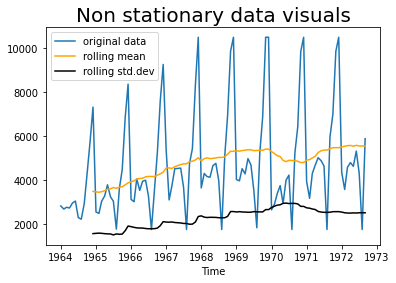

In [22]:
# visualsing data in terms of rolling statistical measures

plt.plot(df,label="original data")
plt.plot(rolling_mean,label="rolling mean",color="orange")
plt.plot(rolling_std_dev,label="rolling std.dev",color="black")
plt.title("Non stationary data visuals",fontsize=20)
plt.xlabel("Time")
plt.legend()
# plt.grid(True)
plt.show()

In [23]:
df['Holiday_Indicator'] = df.index.month.isin([1, 11, 12]).astype(int)

In [24]:
# Ho : Data is not Stationary ----------null hypothesies
# H1 : Data is Stationary -------------alternate hypothesies


def adf_test(sales):
    results=adfuller(sales,  autolag="AIC")
    labels=["ADF statistics","P- value","No.of lags","No. of observations"]
    for key,value in zip(results,labels):
        print(f"[{value}]:{key}")
    if results[1]<=0.05:
        print("Null hypothesies rejected, it comes out to be a stationary sdata")
    else:
        print("Alternate hypothesies rejected,it comes out to be a non stationary data") 

In [25]:
adf_test(df["Sale"])

[ADF statistics]:-1.9415693559012623
[P- value]:0.31276520628944904
[No.of lags]:13
[No. of observations]:91
Alternate hypothesies rejected,it comes out to be a non stationary data


In [26]:
# seasonal differencing

df['seasonal differencing']=df["Sale"]-df["Sale"].shift(12)

In [27]:
df.head(15)

,Sale,Holiday_Indicator,seasonal differencing
Month,,,
1964-01-01,2815.0,1,NaN
1964-02-01,2672.0,0,NaN
1964-03-01,2755.0,0,NaN
1964-04-01,2721.0,0,NaN
1964-05-01,2946.0,0,NaN
1964-06-01,3036.0,0,NaN
1964-07-01,2282.0,0,NaN
1964-08-01,2212.0,0,NaN
1964-09-01,2922.0,0,NaN


In [28]:
# after differncing check for stationarity again

adf_test(df["seasonal differencing"].dropna())

[ADF statistics]:-3.6085272301087183
[P- value]:0.005600082486459144
[No.of lags]:2
[No. of observations]:90
Null hypothesies rejected, it comes out to be a stationary sdata


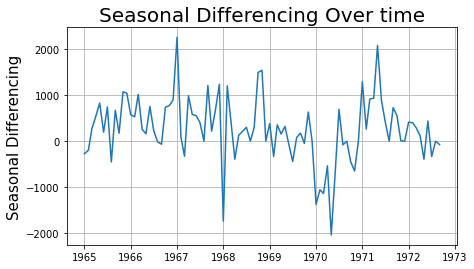

In [29]:
# visualsing the newly transformed (stationary data)

plt.figure(figsize=(7,4))
plt.plot(df["seasonal differencing"])
plt.title("Seasonal Differencing Over time",fontsize=20)
plt.ylabel("Seasonal Differencing",fontsize=15)
plt.grid(True)

<AxesSubplot: title={'center': 'Comparing both the transformed and the original data'}, xlabel='Month'>

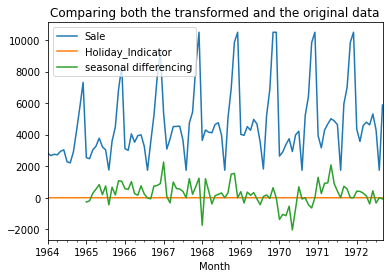

In [30]:
df.plot(title="Comparing both the transformed and the original data", )

In [31]:
df.dropna(inplace=True)

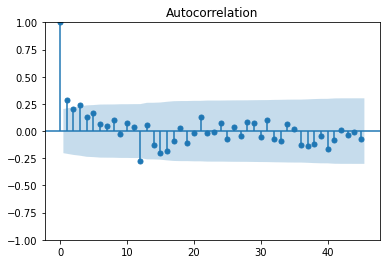

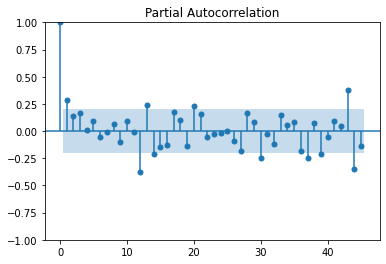

In [32]:
# plot autocorrelation and partialautocorrelation plots to get useful parameters to fit in the model


acf=plot_acf(df["seasonal differencing"],lags=45)
pacf=plot_pacf(df["seasonal differencing"],lags=45)

In [33]:
# pmdarima framework automatically hepls you find out the best suited parameters for your model


model=auto_arima(df["Sale"],trace=True,suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1677.472, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1708.090, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1684.972, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1671.817, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1862.837, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1679.554, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1672.171, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1674.748, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1766.736, Time=0.20 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.272 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -832.909
Date:                Fri, 22 Sep 2023   AIC                           1671.817
Time:                        18:46:03   BIC                           1679.415
Sample:                    01-01-1965   HQIC                          1674.885
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4696.6183    434.762     10.803      0.000    3844.500    5548.736
ma.L1          0.8693      0.061     14.200      0.000       0.749       0.989
sigma2      3.449e+06   5.06e+05      6.819      0.000    2.46e+06    4.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                14.43
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.88
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
df.head()

,Sale,Holiday_Indicator,seasonal differencing
Month,,,
1965-01-01,2541.0,1,-274.0
1965-02-01,2475.0,0,-197.0
1965-03-01,3031.0,0,276.0
1965-04-01,3266.0,0,545.0
1965-05-01,3776.0,0,830.0


In [35]:
df.isnull().sum()

Sale                     0
Holiday_Indicator        0
seasonal differencing    0
dtype: int64

**Model Selection and Training**

In [36]:
# define train and test set
train=df.iloc[:-24]
test=df.iloc[-24:]
print(train.shape,test.shape)

(69, 3) (24, 3)


In [37]:
# train the model
model= SARIMAX(train["Sale"], order=(1, 1, 1), seasonal_order=(2, 0, 2, 12), enforce_stationarity=True, enforce_invertibility=True)
#model_=SARIMAX(train["Sale"],order=(2,0,2),seasonal_order =(2, 0, 2, 12))
model_=model.fit(disp=False)
model_.summary()

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Sale   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -573.359
Date:                                 Fri, 22 Sep 2023   AIC                           1160.717
Time:                                         18:46:05   BIC                           1176.254
Sample:                                     01-01-1965   HQIC                          1166.873
                                          - 09-01-1970                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2959      0.151      1.959      0.050      -0.000       0.592
ma.L1         -0.8893      0.087    -10.248      0.000      -1.059      -0.719
ar.S.L12       1.9396      0.144     13.504      0.000       1.658       2.221
ar.S.L24      -0.9396      0.114     -8.214      0.000      -1.164      -0.715
ma.S.L12      -1.1900      0.278     -4.278      0.000      -1.735      -0.645
ma.S.L24       0.1901      0.131      1.447      0.148      -0.067       0.448
sigma2      6.592e+05   4.83e-07   1.36e+12      0.000    6.59e+05    6.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                33.75
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.41
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+27. Standard errors may be unstable.
"""

**Model Evaluation**

In [38]:
start=len(train)
end= len(train)+len(test)-1

predictions = model_.predict(start,end,
                             typ = 'levels').rename("Predictions")

<AxesSubplot: xlabel='Month'>

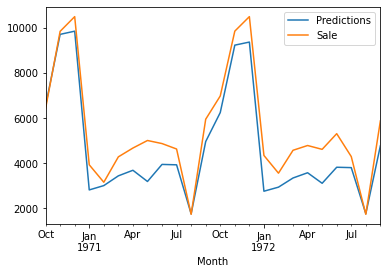

In [39]:
# plot the predictions

predictions.plot(legend=True)
test["Sale"].plot(legend=True)

In [40]:
# Forecast for the next 3 years

model_=SARIMAX(df["Sale"],order=(1,1,1),seasonal_order =(2, 0, 2, 12))
model_=model_.fit(disp=False)

forecast = model_.predict(start = len(df), 
                          end = (len(df)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
forecast

1972-10-01     7001.755847
1972-11-01     9794.350223
1972-12-01    10478.823525
1973-01-01     4710.991787
1973-02-01     4240.260011
1973-03-01     4927.163710
1973-04-01     5083.461775
1973-05-01     5096.140267
1973-06-01     5339.732944
1973-07-01     4739.564302
1973-08-01     2498.812160
1973-09-01     5865.827661
1973-10-01     6973.595248
1973-11-01     9719.880207
1973-12-01    10395.661386
1974-01-01     4731.201892
1974-02-01     4273.034047
1974-03-01     4950.382948
1974-04-01     5106.266457
1974-05-01     5120.895321
1974-06-01     5363.594554
1974-07-01     4776.673628
1974-08-01     2578.104021
1974-09-01     5887.055468
1974-10-01     6977.705711
1974-11-01     9676.812817
1974-12-01    10342.307257
1975-01-01     4784.087468
1975-02-01     4334.885402
1975-03-01     5002.097733
1975-04-01     5157.326155
1975-05-01     5173.842444
1975-06-01     5412.883175
1975-07-01     4837.920860
1975-08-01     2680.380593
1975-09-01     5931.636001
Freq: MS, Name: Forecast, dt

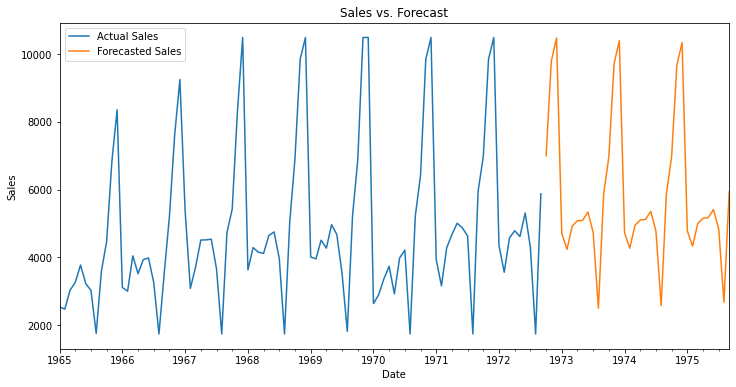

In [42]:
# Set the figure size 
plt.figure(figsize=(12, 6))  


df["Sale"].plot(legend=True, label="Actual Sales")
forecast.plot(legend=True, label="Forecasted Sales")


plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales vs. Forecast")


plt.show()

In [43]:
# Make predictions on the test set
forecast = model_.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Calculate metrics
mae = mean_absolute_error(test["Sale"], forecast_mean)
rmse = np.sqrt(mean_squared_error(test["Sale"], forecast_mean))
r2 = r2_score(test["Sale"], forecast_mean)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 372.55637040531354
Root Mean Squared Error (RMSE): 482.85396353124594
R-squared (R2): 0.9598605495526561


**Hyperparameter Tuning**

In [44]:
p_values = [0, 1, 2]  # values for p
d_values = [0, 1]     # values for d
q_values = [0, 1, 2]  # values for q
P_values = [0, 1]     # values for P
D_values = [0, 1]     # values for D
Q_values = [0, 1]     # values for Q
s_values = [12]       # value for seasonal periodicity

# Create a list of all possible combinations of hyperparameters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_aic = float("inf")
best_params = None

# Perform grid search to find the best hyperparameters
for params in param_combinations:
    p, d, q, P, D, Q, s = params
    try:
        model = sm.tsa.SARIMAX(train["Sale"], order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit(disp=False)
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_params = params
    except:
        continue

print("Best AIC:", best_aic)
print("Best Parameters:", best_params)


C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

Best AIC: 906.1964103373257
Best Parameters: (1, 1, 2, 1, 1, 1, 12)


C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
besr_model= SARIMAX(train["Sale"], order=(1, 1, 2), seasonal_order=(1, 1, 1, 12), enforce_stationarity=True, enforce_invertibility=True)
#model_=SARIMAX(train["Sale"],order=(2,0,2),seasonal_order =(2, 0, 2, 12))
model_best=besr_model.fit(disp=False)
model_best.summary()

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Sale   No. Observations:                   69
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -447.098
Date:                              Fri, 22 Sep 2023   AIC                            906.196
Time:                                      18:47:34   BIC                            918.349
Sample:                                  01-01-1965   HQIC                           910.908
                                       - 09-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6363      0.133     -4.778      0.000      -0.897      -0.375
ma.L1          0.2453      0.151      1.628      0.103      -0.050       0.541
ma.L2         -0.6286      0.106     -5.938      0.000      -0.836      -0.421
ar.S.L12      -0.8856      0.323     -2.744      0.006      -1.518      -0.253
ma.S.L12       0.7076      0.481      1.472      0.141      -0.234       1.650
sigma2      4.351e+05   1.01e+05      4.294      0.000    2.37e+05    6.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.70   Prob(JB):                         0.94
Heteroskedasticity (H):               0.87   Skew:                             0.06
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

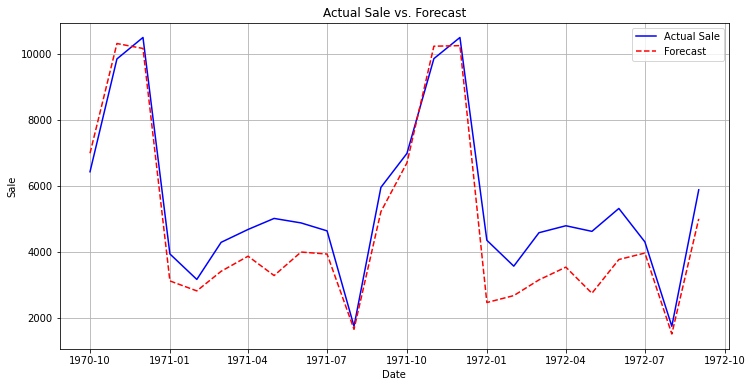

In [46]:

forecast = model_best.get_forecast(steps=len(test))
predicted_values = forecast.predicted_mean

#Create a DataFrame with actual sales and forecasted values
forecast_df = pd.DataFrame({'Date': test.index, 'Actual_Sale': test['Sale'].values, 'Forecast': predicted_values})

# Plot the actual sales and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual_Sale'], label='Actual Sale', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sale')
plt.title('Actual Sale vs. Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Forecast for the next 3 years

model_=SARIMAX(df["Sale"],order=(1,1,2),seasonal_order =(1, 1, 1, 12))
model_=model_.fit(disp=False)

forecast_for_best = model_.predict(start = len(df), 
                          end = (len(df)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')

C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mahed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


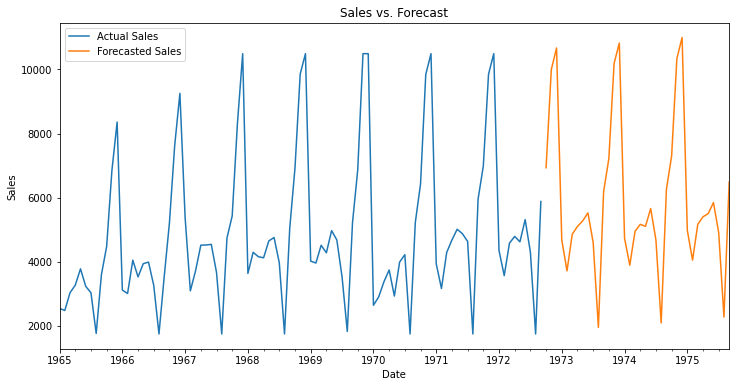

In [48]:
plt.figure(figsize=(12, 6))


df["Sale"].plot(legend=True, label="Actual Sales")
forecast_for_best.plot(legend=True, label="Forecasted Sales")


plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales vs. Forecast")

plt.show()

In [49]:
forecast_for_best

1972-10-01     6930.617742
1972-11-01     9995.774354
1972-12-01    10669.144448
1973-01-01     4677.955261
1973-02-01     3712.368798
1973-03-01     4856.306819
1973-04-01     5098.799320
1973-05-01     5273.514761
1973-06-01     5521.200447
1973-07-01     4598.507778
1973-08-01     1947.412821
1973-09-01     6187.642160
1973-10-01     7217.552007
1973-11-01    10188.570205
1973-12-01    10823.425778
1974-01-01     4732.893432
1974-02-01     3890.215813
1974-03-01     4944.680737
1974-04-01     5164.968181
1974-05-01     5101.495469
1974-06-01     5657.725067
1974-07-01     4671.923940
1974-08-01     2086.711439
1974-09-01     6254.043991
1974-10-01     7300.345339
1974-11-01    10336.458218
1974-12-01    10997.945160
1975-01-01     4976.105813
1975-02-01     4048.440285
1975-03-01     5164.773251
1975-04-01     5400.414833
1975-05-01     5501.642246
1975-06-01     5844.522777
1975-07-01     4902.359299
1975-08-01     2271.591011
1975-09-01     6489.329553
Freq: MS, Name: Forecast, dt

In [50]:
forecast = model_best.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean


mae = mean_absolute_error(test["Sale"], forecast_mean)
rmse = np.sqrt(mean_squared_error(test["Sale"], forecast_mean))
r2 = r2_score(test["Sale"], forecast_mean)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 816.6041586784186
Root Mean Squared Error (RMSE): 974.2404125675147
R-squared (R2): 0.8365924561987641


**try for prophet**

In [51]:
!pip install prophet

In [52]:
prophet_data = train.copy()
prophet_data.reset_index(inplace=True)
prophet_data.rename(columns={'Month': 'ds', 'Sale': 'y'}, inplace=True)

In [53]:
prophet_data

,ds,y,Holiday_Indicator,seasonal differencing
0,1965-01-01,2541.0,1,-274.0
1,1965-02-01,2475.0,0,-197.0
2,1965-03-01,3031.0,0,276.0
3,1965-04-01,3266.0,0,545.0
4,1965-05-01,3776.0,0,830.0
...,...,...,...,...
64,1970-05-01,2927.0,0,-2041.0
65,1970-06-01,3986.0,0,-691.0
66,1970-07-01,4217.0,0,694.0
67,1970-08-01,1742.2,0,-78.8


In [54]:
from prophet import Prophet


prophet_model = Prophet()
prophet_model.fit(prophet_data)

18:47:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:48 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = prophet_model.make_future_dataframe(periods=len(test))
future.tail()

,ds
88,1970-09-21
89,1970-09-22
90,1970-09-23
91,1970-09-24
92,1970-09-25


In [56]:
forecast_prophet = prophet_model.predict(future)

forecast_prophet = forecast_prophet.set_index('ds')['yhat'].tail(len(test))

mae_prophet = mean_absolute_error(test["Sale"], forecast_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test["Sale"], forecast_prophet))

print("Prophet Mean Absolute Error (MAE):", mae_prophet)
print("Prophet Root Mean Squared Error (RMSE):", rmse_prophet)


Prophet Mean Absolute Error (MAE): 7394.628460865562
Prophet Root Mean Squared Error (RMSE): 8213.832032822776


In [57]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
